# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Scalar

### Reverse-mode autodiff

In [2]:
x = Scalar(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

45.0
62.0


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

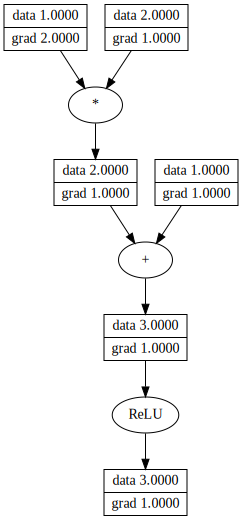

In [4]:
x = Scalar(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2)
print(n)
print(n.parameters())

ReLUNeuron(2)
[Scalar(data=0.23550571390294128, grad=0), Scalar(data=0.06653114721000164, grad=0), Scalar(data=0, grad=0)]


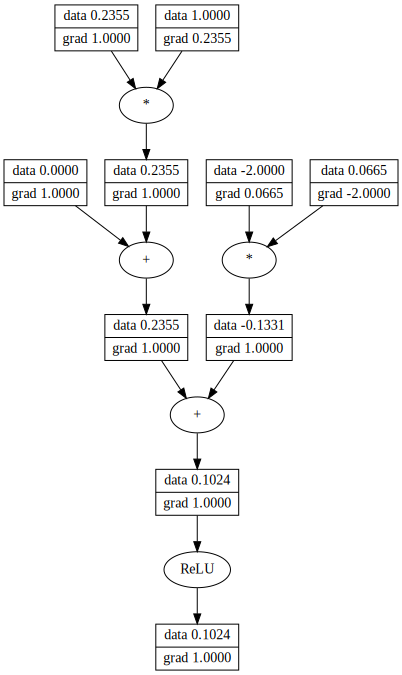

In [6]:
n.zero_grad()
x = [Scalar(1.0), Scalar(-2.0)]
y = n(x)
y.backward()
draw_dot(y)

### Learning XOR

In [7]:
from pyfit.engine import Scalar

inputs = [list(map(Scalar, x)) for x in [[0, 0], [0, 1], [1, 0], [1, 1]]]
print(inputs)
targets = [Scalar(0), Scalar(1), Scalar(1), Scalar(0)]

[[Scalar(data=0, grad=0), Scalar(data=0, grad=0)], [Scalar(data=0, grad=0), Scalar(data=1, grad=0)], [Scalar(data=1, grad=0), Scalar(data=0, grad=0)], [Scalar(data=1, grad=0), Scalar(data=1, grad=0)]]


In [12]:
from pyfit.nn import MLP

model = MLP(2, [4, 1]) # 1 hidden layer
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [LinearNeuron(4)]]
Number of parameters: 17


In [13]:
from pyfit.optim import SGD
from pyfit.loss import MSELoss
from pyfit.data import BatchIterator

optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = MSELoss()
iterator = BatchIterator()

for epoch in range(500):
    # Reset the gradients of model parameters
    optimizer.zero_grad()
    epoch_loss = Scalar(0)
    for batch in iterator(inputs, targets):
        # Forward pass
        outputs = list(map(model, batch.inputs))
        # Loss computation
        y_pred = [item for sublist in outputs for item in sublist]
        batch_loss = loss(y_pred, batch.targets)
        epoch_loss += batch_loss
        # Backprop and gradient descent
        batch_loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, loss = {batch_loss.data}")
    #print(model.parameters())

Epoch 0, loss = 0.575013967340113
Epoch 1, loss = 0.35445966862929434
Epoch 2, loss = 0.3255642033228958
Epoch 3, loss = 0.3148464510757323
Epoch 4, loss = 0.3063058886695029
Epoch 5, loss = 0.2985390852038626
Epoch 6, loss = 0.2913445184455691
Epoch 7, loss = 0.28462841217611223
Epoch 8, loss = 0.2783183026351302
Epoch 9, loss = 0.2723539276726813
Epoch 10, loss = 0.2666845298574186
Epoch 11, loss = 0.26126708254811437
Epoch 12, loss = 0.25606491635929973
Epoch 13, loss = 0.25104662970169633
Epoch 14, loss = 0.24618521774797703
Epoch 15, loss = 0.2414573720013915
Epoch 16, loss = 0.2382024599058447
Epoch 17, loss = 0.23547541207575995
Epoch 18, loss = 0.23280883244207698
Epoch 19, loss = 0.2301879692768558
Epoch 20, loss = 0.2276012720898359
Epoch 21, loss = 0.22503856376250556
Epoch 22, loss = 0.2224907327045353
Epoch 23, loss = 0.21994959102825987
Epoch 24, loss = 0.21740776538205414
Epoch 25, loss = 0.2148586063622438
Epoch 26, loss = 0.21229611334431434
Epoch 27, loss = 0.20971487

Epoch 400, loss = 3.2194631778909008e-06
Epoch 401, loss = 3.4335078525322598e-06
Epoch 402, loss = 2.973560770244086e-06
Epoch 403, loss = 2.9667510484831785e-06
Epoch 404, loss = 2.8213311317065813e-06
Epoch 405, loss = 2.871591830930039e-06
Epoch 406, loss = 2.6303602280884548e-06
Epoch 407, loss = 2.564173133447828e-06
Epoch 408, loss = 2.4576301237864744e-06
Epoch 409, loss = 2.6478143084270707e-06
Epoch 410, loss = 2.2361595118706055e-06
Epoch 411, loss = 2.273639487599908e-06
Epoch 412, loss = 2.166127553696605e-06
Epoch 413, loss = 2.195257345889326e-06
Epoch 414, loss = 1.9815408341842344e-06
Epoch 415, loss = 1.9652715548214593e-06
Epoch 416, loss = 1.8602886743699734e-06
Epoch 417, loss = 1.9063512081596057e-06
Epoch 418, loss = 1.7381083621851874e-06
Epoch 419, loss = 1.6996987319757614e-06
Epoch 420, loss = 1.63132893404045e-06
Epoch 421, loss = 1.7552349351312945e-06
Epoch 422, loss = 1.4988143431894813e-06
Epoch 423, loss = 1.5095685350035554e-06
Epoch 424, loss = 1.4365